In [1]:
import os
import re
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2024-05-22 20:54:35.643634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 20:54:35.867930: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def get_info(path):
    # path: run path
    name = os.path.split(path)[1]

    with open(os.path.join(path, f'{name}_tag_1_banner.txt')) as f:
        for line in f.readlines():

            #  Integrated weight (pb)  :       0.020257
            match = re.match('#  Integrated weight \(pb\)  : +(\d+\.\d+)', line)
            if match:
                # unit: fb
                cross_section = float(match.group(1)) * 1000
            #  Number of Events        :       100000
            match = re.match('#  Number of Events        :       (\d+)', line)
            if match:
                # unit: fb
                nevent = int(match.group(1))

    return cross_section, nevent

In [3]:
def compute_nevent_in_SR_SB(sensitivity=1.0):
    results_s = np.load('../Sample/HVmodel/data/selection_results_SB_4400_5800_s.npy', allow_pickle=True).item()
    results_b = np.load('../Sample/HVmodel/data/selection_results_SB_4400_5800_b.npy', allow_pickle=True).item()

    # Total cross section and number of events
    xection, _ = get_info('../Sample/ppjj/Events/run_03')

    # cross section in signal region and sideband region
    cross_section_SR = results_b['cutflow_number']['Signal region'] / results_b['cutflow_number']['Total'] * xection
    cross_section_SB = results_b['cutflow_number']['Sideband region'] / results_b['cutflow_number']['Total'] * xection
    print(f'Background cross section, SR: {cross_section_SR:.2f} fb, SB: {cross_section_SB:.2f} fb')

    # number of background events in signal region and sideband region
    L = 139 * 1
    n_SR_B = cross_section_SR * L
    n_SB_B = cross_section_SB * L

    print(f'Background sample size: SR: {n_SR_B:.1f}, SB: {n_SB_B:.1f}')

    n_SR_S = sensitivity * np.sqrt(n_SR_B)
    n_SB_S = n_SR_S * results_s['cutflow_number']['Sideband region'] / results_s['cutflow_number']['Signal region']
    print(f'Signal sample size: SR: {n_SR_S:.1f}, SB: {n_SB_S:.1f}')

    return n_SR_S, n_SR_B, n_SB_S, n_SB_B

In [4]:
def load_samples(path):
    root, _ = os.path.splitext(path)
    X = np.load(f'{root}-data.npy')
    Y = np.load(f'{root}-label.npy')
    return X, Y

In [5]:
def get_SR_SB_sample_from(npy_dirs: list, nevents: tuple, seed=0):
    # npy_dirs: list of npy directories
    # nevents: tuple of (n_sig_SR, n_sig_SB, n_bkg_SR, n_bkg_SB)
    data_SR = None
    label_SR = None

    data_SB = None
    label_SB = None

    data_sig_SR = np.load(os.path.join(npy_dirs[0], 'sig_in_SR-data.npy'))
    data_sig_SB = np.load(os.path.join(npy_dirs[0], 'sig_in_SB-data.npy'))
    data_bkg_SR = np.load(os.path.join(npy_dirs[0], 'bkg_in_SR-data.npy'))
    data_bkg_SB = np.load(os.path.join(npy_dirs[0], 'bkg_in_SB-data.npy'))

    n_sig_SR, n_sig_SB, n_bkg_SR, n_bkg_SB = nevents

    np.random.seed(seed)
    idx_sig_SR = np.random.choice(data_sig_SR.shape[0], n_sig_SR, replace=False)
    idx_sig_SB = np.random.choice(data_sig_SB.shape[0], n_sig_SB, replace=False)
    idx_bkg_SR = np.random.choice(data_bkg_SR.shape[0], n_bkg_SR, replace=False)
    idx_bkg_SB = np.random.choice(data_bkg_SB.shape[0], n_bkg_SB, replace=False)

    print(f'Preparing dataset from {npy_dirs}')
    for npy_dir in npy_dirs:

        data_sig_SR = np.load(os.path.join(npy_dir, 'sig_in_SR-data.npy'))
        data_sig_SB = np.load(os.path.join(npy_dir, 'sig_in_SB-data.npy'))
        data_bkg_SR = np.load(os.path.join(npy_dir, 'bkg_in_SR-data.npy'))
        data_bkg_SB = np.load(os.path.join(npy_dir, 'bkg_in_SB-data.npy'))

        new_data_SR = np.concatenate([
            data_sig_SR[idx_sig_SR],
            data_bkg_SR[idx_bkg_SR],
        ], axis=0)

        if data_SR is None:
            data_SR = new_data_SR
        else:
            data_SR = np.concatenate([data_SR, new_data_SR], axis=0)

        new_label_SR = np.zeros(n_sig_SR + n_bkg_SR)
        new_label_SR[:n_sig_SR] = 1

        if label_SR is None:
            label_SR = new_label_SR
        else:
            label_SR = np.concatenate([label_SR, new_label_SR])

        new_data_SB = np.concatenate([
            data_sig_SB[idx_sig_SB],
            data_bkg_SB[idx_bkg_SB],
        ], axis=0)

        if data_SB is None:
            data_SB = new_data_SB
        else:
            data_SB = np.concatenate([data_SB, new_data_SB], axis=0)

        new_label_SB = np.zeros(n_sig_SB + n_bkg_SB)
        new_label_SB[:n_sig_SB] = 1

        if label_SB is None:
            label_SB = new_label_SB
        else:
            label_SB = np.concatenate([label_SB, new_label_SB])

    return data_SR, label_SR, data_SB, label_SB

In [6]:
def get_ratio_and_std(n1, n2):
    ratio = np.divide(n1, n2)
    std = ratio * np.sqrt(1/n1 + 1/n2)
    return ratio, std

In [7]:
def plot_event_score_distribution(X_SRSB, y_SRSB, model_name, sample_type='Train', nbins_SB=(20, 50), hist_range=(0.4, 0.7), save_path=None):
    save_model_name = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
    loaded_model = tf.keras.models.load_model(save_model_name)
    
    nbins_S, nbins_B = nbins_SB

    X_SR, X_SB = X_SRSB
    y_SR, y_SB = y_SRSB

    fig, ax = plt.subplots(2, 1, figsize=(5, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

    # 在圖上畫出 SR, SB 的分布與比例
    SR_B_score = loaded_model.predict(X_SR[y_SR==0])
    SB_B_score = loaded_model.predict(X_SB[y_SB==0])
    SR_S_score = loaded_model.predict(X_SR[y_SR==1]) if (y_SR==1).any() else []
    SB_S_score = loaded_model.predict(X_SB[y_SB==1]) if (y_SR==1).any() else []

    # plot distribution
    ax[0].hist(SR_B_score, bins=nbins_B, range=hist_range, histtype='step', linestyle='-', color='b', label=f'SR, {sample_type} Background', density=True)
    ax[0].hist(SB_B_score, bins=nbins_B, range=hist_range, histtype='step', linestyle='--',color='b', label=f'SB, {sample_type} Background', density=True)
    ax[0].hist(SR_S_score, bins=nbins_S, range=hist_range, histtype='step', linestyle='-', color='r', label=f'SR, {sample_type} Signal', density=True)
    ax[0].hist(SB_S_score, bins=nbins_S, range=hist_range, histtype='step', linestyle='--',color='r', label=f'SB, {sample_type} Signal', density=True)

    # get number in each bin
    n_SR_B, edges_B = np.histogram(SR_B_score, bins=nbins_B, range=hist_range)
    n_SB_B, edges_B = np.histogram(SB_B_score, bins=nbins_B, range=hist_range)
    n_SR_S, edges_S = np.histogram(SR_S_score, bins=nbins_S, range=hist_range)
    n_SB_S, edges_S = np.histogram(SB_S_score, bins=nbins_S, range=hist_range)

    # plot ratio
    r_B = SR_B_score.shape[0] / SB_B_score.shape[0]
    r_S = SR_S_score.shape[0] / SB_S_score.shape[0] if (y_SR==1).any() else 1
    ratio_B, ratio_std_B = get_ratio_and_std(n_SR_B, n_SB_B)
    ratio_S, ratio_std_S = get_ratio_and_std(n_SR_S, n_SB_S)

    ax[1].plot(edges_B[:-1], ratio_B / r_B, color='b', label='Background')
    ax[1].plot(edges_S[:-1], ratio_S / r_S, color='r', label='Signal')
    ax[1].fill_between(edges_B[:-1], (ratio_B - ratio_std_B) / r_B, (ratio_B + ratio_std_B) / r_B, color='b', alpha=0.3)
    ax[1].fill_between(edges_S[:-1], (ratio_S - ratio_std_S) / r_S, (ratio_S + ratio_std_S) / r_S, color='r', alpha=0.3)


    ax[0].set_title('Event score distribution')
    ax[0].set_ylabel('Density')
    ax[0].legend(frameon=False,)

    ax[1].axhline(y=1, color='grey', linestyle='--')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Event score')
    ax[1].set_ylabel('Ratio')
    ax[1].legend(frameon=False,)

    if save_path is not None:
        plt.savefig(save_path, dpi=300, facecolor='White', bbox_inches='tight')
    plt.show()

# Signal and Sideband regions

## Original

In [8]:
config_file = 'config_files/origin_config_12.json'

with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
val_npy_paths = config['val_npy_paths']
seed = config['seed']
sensitivity = config['sensitivity']

true_label_path = config['true_label_path']
model_name = config['model_name']
sample_type = config['sample_type']

# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = compute_nevent_in_SR_SB(sensitivity=sensitivity)

train_nevents = int(n_SR_S * r_train), int(n_SB_S * r_train), int(n_SR_B * r_train), int(n_SB_B * r_train)
X_train_SR, y_train_SR, X_train_SB, y_train_SB  = get_SR_SB_sample_from(train_npy_paths, train_nevents, seed=seed)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0
Preparing dataset from ['../Sample/HVmodel/data/origin/25x25']


2024-05-22 20:54:52.042355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 20:54:52.647063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46699 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2024-05-22 20:54:55.617075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


 34/474 [=>............................] - ETA: 2s

2024-05-22 20:54:57.265677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


506/506 [==============================] - 3s 5ms/step


/home/r10222035/.conda/envs/tf2/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_82643/766112285.py:2: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(n1, n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1/n1 + 1/n2)


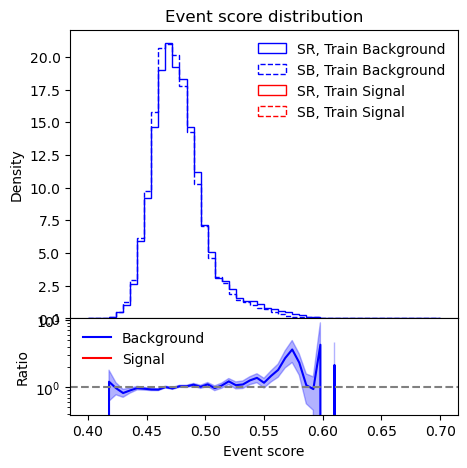

313/313 [==============================] - 1s 5ms/step


/tmp/ipykernel_82643/766112285.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = np.divide(n1, n2)
/tmp/ipykernel_82643/766112285.py:2: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(n1, n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_82643/397522604.py:38: RuntimeWarning: invalid value encountered in subtract
  ax[1].fill_between(edges_B[:-1], (ratio_B - ratio_std_B) / r_B, (ratio_B + ratio_std_B) / r_B, color='b', alpha=0.3)


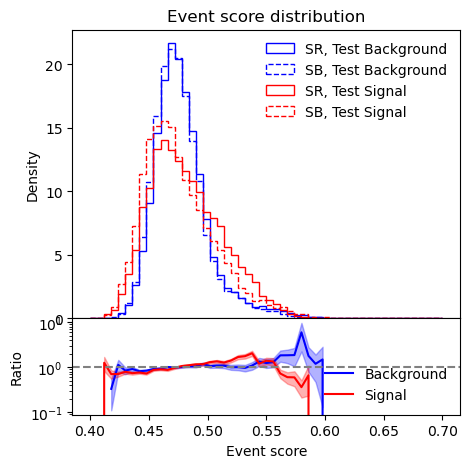

In [9]:
save_path = f'../figures/HVmodel_event_score_origin_train_SB_0_res_25.pdf'
plot_event_score_distribution(X_SRSB=(X_train_SR, X_train_SB), 
                              y_SRSB=(y_train_SR, y_train_SB), 
                              sample_type='Train', 
                              nbins_SB=(20, 50), 
                              model_name=model_name, 
                              save_path=save_path)


X_test_SR, y_test_SR = load_samples(true_label_path)
X_test_SB, y_test_SB = load_samples('../Sample/HVmodel/data/split_val/25x25/mix_sample_test-SB_25x25.npy')

save_path = f'../figures/HVmodel_event_score_origin_test_SB_0_res_25.pdf'
plot_event_score_distribution(X_SRSB=(X_test_SR, X_test_SB),
                              y_SRSB=(y_test_SR, y_test_SB), 
                              sample_type='Test', 
                              nbins_SB=(50, 50), 
                              model_name=model_name,
                              save_path=save_path)

## +3 jet rotation

In [10]:
config_file = 'config_files/jet_aug_3_config_01.json'

with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
val_npy_paths = config['val_npy_paths']
seed = config['seed']
sensitivity = config['sensitivity']

true_label_path = config['true_label_path']
model_name = config['model_name']
sample_type = config['sample_type']

# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = compute_nevent_in_SR_SB(sensitivity=sensitivity)

train_nevents = int(n_SR_S * r_train), int(n_SB_S * r_train), int(n_SR_B * r_train), int(n_SB_B * r_train)
X_train_SR, y_train_SR, X_train_SB, y_train_SB  = get_SR_SB_sample_from(train_npy_paths, train_nevents, seed=seed)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0


Preparing dataset from ['../Sample/HVmodel/data/origin/25x25', '../Sample/HVmodel/data/jet_rotation/25x25/01', '../Sample/HVmodel/data/jet_rotation/25x25/02', '../Sample/HVmodel/data/jet_rotation/25x25/03']


2024/2024 [==============================] - 10s 5ms/step


/home/r10222035/.conda/envs/tf2/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_82643/766112285.py:2: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(n1, n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1/n1 + 1/n2)


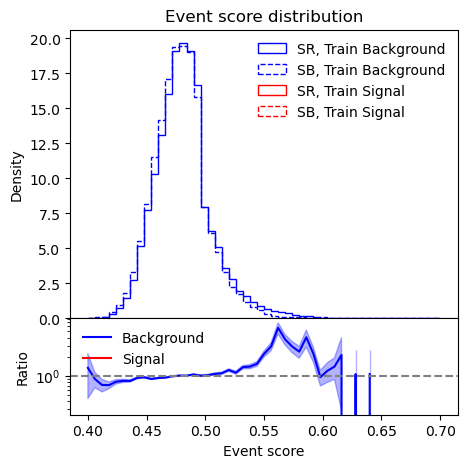

313/313 [==============================] - 2s 5ms/step


/tmp/ipykernel_82643/766112285.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = np.divide(n1, n2)
/tmp/ipykernel_82643/766112285.py:2: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(n1, n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_82643/397522604.py:38: RuntimeWarning: invalid value encountered in subtract
  ax[1].fill_between(edges_B[:-1], (ratio_B - ratio_std_B) / r_B, (ratio_B + ratio_std_B) / r_B, color='b', alpha=0.3)


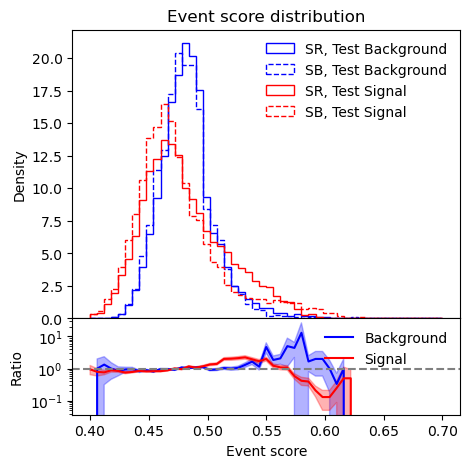

In [11]:
save_path = f'../figures/HVmodel_event_score_jet_aug_3_train_SB_0_res_25.pdf'
plot_event_score_distribution(X_SRSB=(X_train_SR, X_train_SB), 
                              y_SRSB=(y_train_SR, y_train_SB), 
                              sample_type='Train', 
                              nbins_SB=(20, 50), 
                              model_name=model_name, 
                              save_path=save_path)


X_test_SR, y_test_SR = load_samples(true_label_path)
X_test_SB, y_test_SB = load_samples('../Sample/HVmodel/data/split_val/25x25/mix_sample_test-SB_25x25.npy')

save_path = f'../figures/HVmodel_event_score_jet_aug_3_test_SB_0_res_25.pdf'
plot_event_score_distribution(X_SRSB=(X_test_SR, X_test_SB),
                              y_SRSB=(y_test_SR, y_test_SB), 
                              sample_type='Test', 
                              nbins_SB=(50, 50), 
                              model_name=model_name,
                              save_path=save_path)

## +3 $p_\text{T}$ smearing + Jet rotation

In [12]:
config_file = 'config_files/pt_jet_aug_3_config_01.json'

with open(config_file) as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
val_npy_paths = config['val_npy_paths']
seed = config['seed']
sensitivity = config['sensitivity']

true_label_path = config['true_label_path']
model_name = config['model_name']
sample_type = config['sample_type']

# Training and validation splitting ratio
r_train, r_val = 0.8, 0.2

n_SR_S, n_SR_B, n_SB_S, n_SB_B = compute_nevent_in_SR_SB(sensitivity=sensitivity)

train_nevents = int(n_SR_S * r_train), int(n_SB_S * r_train), int(n_SR_B * r_train), int(n_SB_B * r_train)
X_train_SR, y_train_SR, X_train_SB, y_train_SB  = get_SR_SB_sample_from(train_npy_paths, train_nevents, seed=seed)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0


Preparing dataset from ['../Sample/HVmodel/data/origin/25x25', '../Sample/HVmodel/data/pt_smearing_jet_rotation/25x25/01', '../Sample/HVmodel/data/pt_smearing_jet_rotation/25x25/02', '../Sample/HVmodel/data/pt_smearing_jet_rotation/25x25/03']


2024/2024 [==============================] - 10s 5ms/step


/home/r10222035/.conda/envs/tf2/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_82643/766112285.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = np.divide(n1, n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_82643/766112285.py:2: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(n1, n2)
/tmp/ipykernel_82643/397522604.py:38: RuntimeWarning: invalid value encountered in subtract
  ax[1].fill_between(edges_B[:-1], (ratio_B - ratio_std_B) / r_B, (ratio_B + ratio_std_B) / r_B, color='b', alpha=0.3)


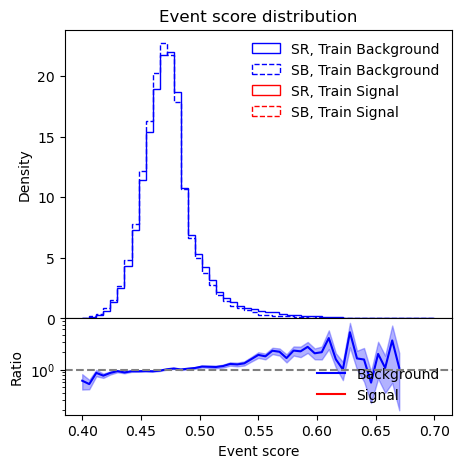

313/313 [==============================] - 2s 5ms/step


/tmp/ipykernel_82643/766112285.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = np.divide(n1, n2)
/tmp/ipykernel_82643/766112285.py:2: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(n1, n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: divide by zero encountered in divide
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_82643/766112285.py:3: RuntimeWarning: invalid value encountered in multiply
  std = ratio * np.sqrt(1/n1 + 1/n2)
/tmp/ipykernel_82643/397522604.py:38: RuntimeWarning: invalid value encountered in subtract
  ax[1].fill_between(edges_B[:-1], (ratio_B - ratio_std_B) / r_B, (ratio_B + ratio_std_B) / r_B, color='b', alpha=0.3)


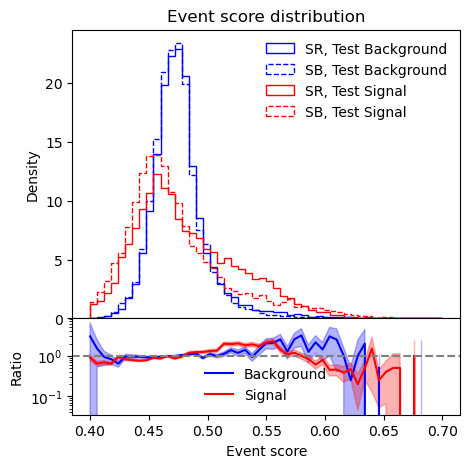

In [13]:
save_path = f'../figures/HVmodel_event_score_pt_jet_aug_3_train_SB_0_res_25.pdf'
plot_event_score_distribution(X_SRSB=(X_train_SR, X_train_SB), 
                              y_SRSB=(y_train_SR, y_train_SB), 
                              sample_type='Train', 
                              nbins_SB=(20, 50), 
                              model_name=model_name, 
                              save_path=save_path)


X_test_SR, y_test_SR = load_samples(true_label_path)
X_test_SB, y_test_SB = load_samples('../Sample/HVmodel/data/split_val/25x25/mix_sample_test-SB_25x25.npy')

save_path = f'../figures/HVmodel_event_score_pt_jet_aug_3_test_SB_0_res_25.pdf'
plot_event_score_distribution(X_SRSB=(X_test_SR, X_test_SB),
                              y_SRSB=(y_test_SR, y_test_SB), 
                              sample_type='Test', 
                              nbins_SB=(50, 50), 
                              model_name=model_name,
                              save_path=save_path)

# Signal region: Training and Testing

In [12]:
X_test, y_test = load_samples(true_label_path)

474/474 [==============================] - 2s 5ms/step


/home/r10222035/.conda/envs/tf2/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_62693/1622040820.py:18: RuntimeWarning: divide by zero encountered in divide
  ratio_B = np.divide(train_B_density, test_B_density)
/tmp/ipykernel_62693/1622040820.py:18: RuntimeWarning: invalid value encountered in divide
  ratio_B = np.divide(train_B_density, test_B_density)


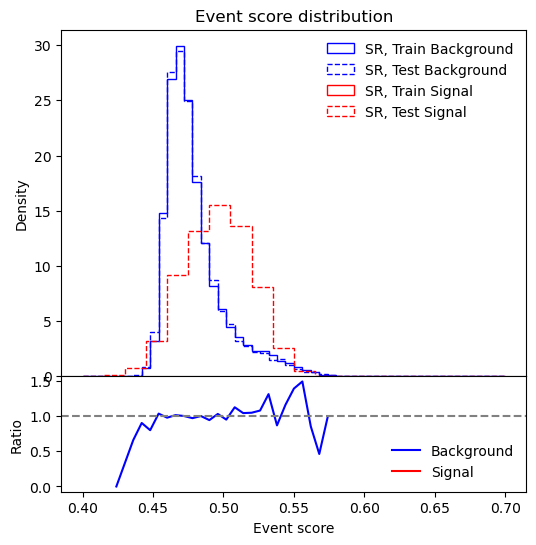

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})

# 在圖上畫出 SR, SB 的分布與比例
test_B_score = loaded_model.predict(X_test[y_test==0])
test_S_score = loaded_model.predict(X_test[y_test==1])
train_B_score = loaded_model.predict(X_train_SR[y_train_SR==0])
train_S_score = loaded_model.predict(X_train_SR[y_train_SR==1]) if sensitivity != 0 else []

train_B_density, edges_B, _ = ax[0].hist(train_B_score, bins=nbins_B, range=hist_range, histtype='step', linestyle='-', color='b', label='SR, Train Background', density=True)
test_B_density, edges_B, _ = ax[0].hist(test_B_score, bins=nbins_B, range=hist_range, histtype='step', linestyle='--', color='b', label='SR, Test Background', density=True)
train_S_density, edges_S, _ = ax[0].hist(train_S_score, bins=nbins_S, range=hist_range, histtype='step', linestyle='-', color='r', label='SR, Train Signal', density=True)
test_S_density, edges_S, _ = ax[0].hist(test_S_score, bins=nbins_S, range=hist_range, histtype='step', linestyle='--', color='r', label='SR, Test Signal', density=True)


ratio_B = np.divide(train_B_density, test_B_density)
ax[1].plot(edges_B[:-1], ratio_B, color='b', label='Background')
ratio_S = np.divide(train_S_density, test_S_density)
ax[1].plot(edges_S[:-1], ratio_S, color='r', label='Signal')


ax[0].set_title('Event score distribution')
ax[0].set_ylabel('Density')
ax[0].legend(frameon=False,)

ax[1].axhline(y=1, color='grey', linestyle='--')
ax[1].set_xlabel('Event score')
ax[1].set_ylabel('Ratio')

ax[1].legend(frameon=False,)

# plt.savefig(f'../figures/HVmodel_event_score_pt_jet_aug_3_train_test_SR_SB_{sensitivity}_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()